In [1]:
# NUMPY
import numpy as np
np.random.seed(3946)
# MATPLOTLIB
import matplotlib.pyplot as plt
plt.style.context('dark_background')
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# WARNINGS
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TIME
from time import time 

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 

# POT
import ot
from ot import sinkhorn, emd

# GREENKHORN 
from ot.bregman import greenkhorn

# SCREENKHORN
from screenkhorn.screenkhorn import Screenkhorn
from screenkhorn.path_regularization import path_regularization_with_restricted_Sinkhorn, path_regularization


## Data generation

In [2]:
n_1 = 200# nb samples
n_2 = 100
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 0.7

K = np.exp(-M/reg)

In [3]:
# plt.scatter(xs[:,0], xs[:,1], marker='^', c='m')
# plt.scatter(xt[:,0], xt[:,1], marker='o', c='g');

## Bounds of $\varepsilon \in (\varepsilon_{\min}, \varepsilon_{\max})$

\begin{equation}
\label{varepsilon_min}
\varepsilon_{\min} = \min\bigg\{\min_{i}\sqrt{\frac{\mu_i}{\sum_{j}K_{ij}}}, \min_{j}\sqrt{\frac{\nu_j}{\sum_{i}K_{ij}}}\bigg\},
\end{equation}
and 
\begin{align}
	\label{varepsilon_max}
	\varepsilon_{\max} = \max\bigg\{\max_{i}\sqrt{\frac{\mu_i}{\sum_{j}K_{ij}}}, \max_{j}\sqrt{\frac{\nu_j}{\sum_{i}K_{ij}}}\bigg\}.
\end{align}

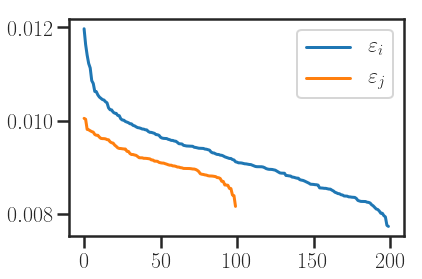

In [4]:
epsilon_tree_a = np.sqrt(a / K.sum(axis=1))
epsilon_tree_a_sort = np.sort(epsilon_tree_a)[::-1]
epsilon_tree_b = np.sqrt(b / K.T.sum(axis=1))
epsilon_tree_b_sort = np.sort(epsilon_tree_b)[::-1]
plt.plot(epsilon_tree_a_sort, label=r'$\varepsilon_i$')
plt.plot(epsilon_tree_b_sort, label=r'$\varepsilon_j$')
plt.legend();

In [60]:
epsilon_tree_ab = np.sort(np.hstack([epsilon_tree_a, epsilon_tree_b]))[::-1]
epsilon_tree_ab_eps_1 = (max(epsilon_tree_ab) - min(epsilon_tree_ab))/2 + min(epsilon_tree_ab)
epsilon_tree_ab_eps_2 = (max(epsilon_tree_ab) - min(epsilon_tree_ab))/20 + min(epsilon_tree_ab)

epsilon_tree_ab_eps = np.array([epsilon_tree_ab_eps_2])

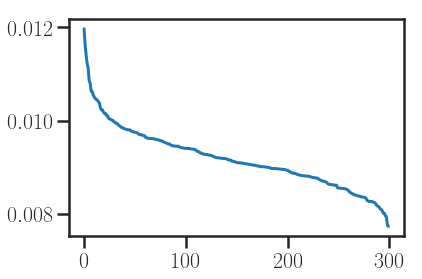

In [61]:
plt.plot(epsilon_tree_ab);

## Restricted Sinkhorn


In [62]:
## Initial points
log_epsilons = np.log(epsilon_tree_ab_eps)
u0 = np.full(n_1, np.max(log_epsilons))
v0 = np.full(n_2, np.max(log_epsilons))

I_test = np.where(a >= np.mean(epsilon_tree_ab_eps)** 2 * K.sum(axis=1))[0].tolist()
J_test = np.where(b >= np.mean(epsilon_tree_ab_eps)** 2 * K.T.sum(axis=1))[0].tolist()

u0[I_test] = - 10 * np.mean(log_epsilons)
v0[J_test] = - 10 * np.mean(log_epsilons)

In [64]:
## Cardinals of I_test and J_test
len(I_test), len(J_test)

(197, 100)

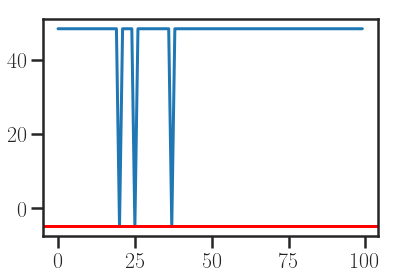

In [65]:
plt.plot(u0[:100]);
plt.axhline(y=np.max(log_epsilons), color='r')

In [66]:
# Initialize Screenkhorn class
epsilon = epsilon_tree_ab_eps[0]
screenkhorn = Screenkhorn(a, b, M, reg, epsilon)

In [67]:
time_start_sinklike = time()
sinkhornlike = screenkhorn.restricted_sinkhorn(u0, v0, I_test, J_test, max_iter=100, tol=1e-9)
                           #trace=True, verbose=False)
time_end = time() - time_start_sinklike
print(time_end)

0.008610248565673828


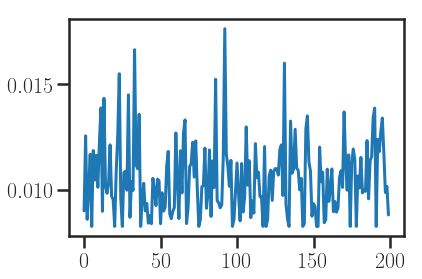

In [31]:
u_sink_like = sinkhornlike["usc"]
v_sink_like = sinkhornlike["vsc"]
plt.plot(u_sink_like)

## Restricted Greenkhorn

In [32]:
time_start_greenlike = time()
greenlike = screenkhorn.restricted_greenkhorn(u0, v0, I_test, J_test, max_iter=1000, tol=1e-9)
time_end_green = time() - time_start_greenlike
print(time_end_green)

999
0.04835700988769531


In [33]:
u_green_like = greenlike["usc"]
v_green_like = greenlike["vsc"]

## Sinkhorn

In [38]:
time_sink = time()
P_sink = sinkhorn(a, b, M, reg, log=True, numItermax=1000, stopThr=1e-19)
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']
time_tc_sink = time() - time_sink
print(time_tc_sink)

0.0020952224731445312


In [35]:
time_end / time_tc_sink 

4.709358499045051

In [36]:
time_end_green /  time_tc_sink 

22.78665318503539

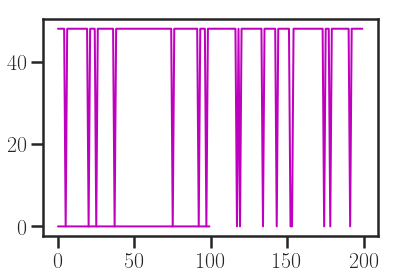

In [37]:
# plt.plot(exp_u_star, linewidth=2, color='r', label=r'$e^{u^\star}$')
# plt.plot(u_sink_like, linewidth=2, color='b', label=r'$e^{u^\star}$');
plt.plot(u_green_like, linewidth=2, color='m', label=r'$e^{u^\star}$');
plt.plot(v_green_like, linewidth=2, color='m', label=r'$e^{u^\star}$');

In [19]:
## choice of solver, the 'acc_proj_grad' is the fastest.
# solver = 'proj_grad' 
# solver = 'block_acc_proj_grad' 
# solver = 'block_proj_grad'
solver = 'acc_proj_grad'

## params of solver
step_size_solver = None
backtracking_solver = False
max_iter_backtracking_solver = 30
max_iter_solver = 1000
tol_solver = 1e-9

time_path = time()
u, v = path_regularization_with_restricted_Sinkhorn(a, b, M, reg, u0, v0, epsilon_tree_ab_eps,
                                                    solver=solver,
                                                    step_size_solver=step_size_solver,
                                                    backtracking_solver=backtracking_solver,
                                                    max_iter_backtracking_solver=max_iter_backtracking_solver,
                                                    max_iter_solver=max_iter_solver,
                                                    tol_solver=tol_solver)

Time spending during restricted Skinkhorn is 0.049201011657714844


In [20]:
# screenkhorn = Screenkhorn(a, b, M, reg, 0.0095) #epsilon_tree_ab_eps[0])
# sol_eps = screenkhorn.projected_grad(u00, v00, I_test, J_test,
                                           # max_iter_backtracking=10,
                                           # step_size=10., max_iter=1000, tol=1e-8, verbose=False)

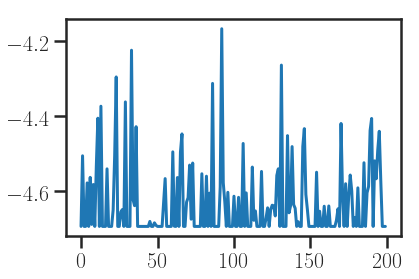

In [21]:
# plt.plot(u0)
# plt.plot(v);
plt.plot(u)
# plt.plot(v);
# plt.plot(v0);

## Sinkhorn's algorithm from POT

In [22]:
time_sink = time()
P_sink = sinkhorn(a, b, M, reg, log=True)
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']
time_tc_sink = time() - time_sink
print(time_tc_sink)

0.0020999908447265625


In [23]:
time_tc_path / time_tc_sink 

NameError: name 'time_tc_path' is not defined

In [ ]:
time_tc_path, time_tc_sink, time_tc_path / time_tc_sink 

## Plots of $e^{u^\star}$ and $e^{v^\star}$ 

In [ ]:
plt.plot(exp_u_star, linewidth=2, color='r', label=r'$e^{u^\star}$')


In [ ]:
C_K = 1.
# C_K = 1e+93
# plt.plot(exp_u_star, linewidth=2, color='r', label=r'$e^{u^\star}$')
plt.plot(np.exp(u)*C_K, linewidth=2, color='b', label=r'$e^{u^\star}$')

# plt.plot(exp_v_star, linewidth=2, color='b', label=r'$e^{v^\star}$')
plt.legend()
plt.subplots_adjust(hspace=.5)
plt.tight_layout()

In [ ]:
#plt.plot(exp_v_star, linewidth=2, color='g', label=r'$e^{u^\star}$')
plt.plot(np.exp(v)/C_K, linewidth=2, color='m', label=r'$e^{u^\star}$')

# plt.plot(exp_v_star, linewidth=2, color='b', label=r'$e^{v^\star}$')
plt.legend()
plt.subplots_adjust(hspace=.5)
plt.tight_layout()

In [ ]:
P_active = np.diag(np.exp(u)*C_K) @ K @ np.diag(np.exp(v)/C_K)
# P_active = np.diag(np.exp(u)) @ K @ np.diag(np.exp(v))

(P_star - P_active).max()

In [ ]:
(P_active @ np.ones(n_2)).sum()

In [ ]:
(P_active.T @ np.ones(n_1)).sum()

In [ ]:
(P_star @ np.ones(n_2)).sum()

In [ ]:
(P_star.T @ np.ones(n_1)).sum()